# NFL Combine Draft Classification  
## A Logistic Regression Analysis

### Eric Au

<img src="https://library.sportingnews.com/styles/twitter_card_120x120/s3/2022-03/Antoine-Winfield-030222-GETTY-FTR.jpg?itok=nG3hUgf_" width="500" length = "200"/>

Source: <a href="https://www.sportingnews.com/us/nfl/news/nfl-combine-drills-explained-40-yard-dash/lds11epxn7znufqyjkaphguq">Getty Images</a>

### Business and Data Understanding

Every year, the National Football League (NFL) holds a week long showcase where college football players, otherwise known as prospects, perform physical drills and tests in front of team coaches, scouts, and general managers. These drills are intended to measure a player's physical ability such as speed, quickness, strength, and overall athleticism. 

But what can NFL teams learn from these workouts? What exactly do the non-football athletic testing measurements contribute to prospect evaluation? These are a questions that many fans ask to this day and NFL teams try to interpret to make the best decision possible when drafting their players. 

For this analysis, we will be using player combine data scraped from <a href = "https://www.pro-football-reference.com/">Pro-Football Reference</a> over the last 22 years (2000-2022). 

Each record represents an individual player who was eligible to be drafted with information related to their combine measurements. Additionally, each record indicates whether that player was `Drafted` with 1 for "Yes" and 0 for "No". This will be further clarified in the preliminary cleaning of the data set. 

**The task is to predict whether a player was `Drafted` based on the available data and information provided in the NFL Combine.** 

**Stakeholders:** The New York Giants front office (General Manager, President, Scouting Department). 


In [18]:
# import libraries 
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve

In [19]:
# load in data
df = pd.read_csv('Data/combine_2000_2022.csv', index_col = 0)
df.head()

,Player,Pos,School,College,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Drafted (tm/rnd/yr),Year
0,John Abraham,OLB,South Carolina,NaN,6-4,252.0,4.55,NaN,NaN,NaN,NaN,NaN,New York Jets / 1st / 13th pick / 2000,2000
1,Shaun Alexander,RB,Alabama,College Stats,6-0,218.0,4.58,NaN,NaN,NaN,NaN,NaN,Seattle Seahawks / 1st / 19th pick / 2000,2000
2,Darnell Alford,OT,Boston Col.,NaN,6-4,334.0,5.56,25.0,23.0,94.0,8.48,4.98,Kansas City Chiefs / 6th / 188th pick / 2000,2000
3,Kyle Allamon,TE,Texas Tech,NaN,6-2,253.0,4.97,29.0,NaN,104.0,7.29,4.49,NaN,2000
4,Rashard Anderson,CB,Jackson State,NaN,6-2,206.0,4.55,34.0,NaN,123.0,7.18,4.15,Carolina Panthers / 1st / 23rd pick / 2000,2000


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7680 entries, 0 to 7820
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Player               7680 non-null   object 
 1   Pos                  7680 non-null   object 
 2   School               7680 non-null   object 
 3   College              6240 non-null   object 
 4   Ht                   7651 non-null   object 
 5   Wt                   7656 non-null   float64
 6   40yd                 7206 non-null   float64
 7   Vertical             5932 non-null   float64
 8   Bench                5096 non-null   float64
 9   Broad Jump           5859 non-null   float64
 10  3Cone                4792 non-null   float64
 11  Shuttle              4895 non-null   float64
 12  Drafted (tm/rnd/yr)  4937 non-null   object 
 13  Year                 7680 non-null   int64  
dtypes: float64(7), int64(1), object(6)
memory usage: 900.0+ KB


## Initial Data Preparation
### Convert to float types in appropriate columns; 

In [21]:
# create a list of columns that need to be floats
col_floats = ['Wt', '40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle']

In [22]:
# convert to type float for col_floats columns
df[col_floats].astype(float)

,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle
0,252.0,4.55,NaN,NaN,NaN,NaN,NaN
1,218.0,4.58,NaN,NaN,NaN,NaN,NaN
2,334.0,5.56,25.0,23.0,94.0,8.48,4.98
3,253.0,4.97,29.0,NaN,104.0,7.29,4.49
4,206.0,4.55,34.0,NaN,123.0,7.18,4.15
...,...,...,...,...,...,...,...
7816,304.0,4.77,29.0,NaN,111.0,NaN,NaN
7817,255.0,NaN,NaN,NaN,NaN,NaN,NaN
7818,206.0,NaN,NaN,12.0,NaN,NaN,NaN
7819,316.0,5.13,28.5,27.0,110.0,7.75,4.71


### Remove missing data

In [23]:
# there are 29 missing heights in the dataframe
missing_heights = df[df['Ht'].isna()].index
len(missing_heights)

29

In [24]:
# remove these rows from the df
df = df.drop(missing_heights)

In [25]:
# check shape (7680 - 29) = 7651
df.shape

(7651, 14)

### Convert `Height` to appropriate float value

In [26]:
# create feet and inches columns to seperate the 'Ht'
df['feet'] = df['Ht'].str.split("-").str[0].astype(int)
df['inches'] = df['Ht'].str.split("-").str[1].astype(int)

# add new Height column that calculates height as a float
df['Height'] = df['feet'] + round((df['inches']/12),2)

In [27]:
# remove unneeded columns and extra columns created
df = df.drop(columns = ['Player', 'Ht', 'College','feet', 'inches'])

In [28]:
# rename the columns
df = df[['Pos', 'School', 'Height', 'Wt', '40yd', 'Vertical', 'Bench',
       'Broad Jump', '3Cone', 'Shuttle', 'Drafted (tm/rnd/yr)', 'Year']]

### Create binary `Drafted ` Column of 1 - Yes, 0 - No if player was drafted

In [29]:
# fill missing in drafted column with 0
df['Drafted (tm/rnd/yr)'] = df['Drafted (tm/rnd/yr)'].fillna(0)

In [30]:
# create new column Drafted that designates whether drafted (1) or not (0)
df['Drafted'] = np.where(df['Drafted (tm/rnd/yr)'] == 0, 0, 1)

# drop extra drafted column now
df.drop(columns = 'Drafted (tm/rnd/yr)', inplace = True)

In [31]:
df.head(5)

,Pos,School,Height,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Year,Drafted
0,OLB,South Carolina,6.33,252.0,4.55,NaN,NaN,NaN,NaN,NaN,2000,1
1,RB,Alabama,6.00,218.0,4.58,NaN,NaN,NaN,NaN,NaN,2000,1
2,OT,Boston Col.,6.33,334.0,5.56,25.0,23.0,94.0,8.48,4.98,2000,1
3,TE,Texas Tech,6.17,253.0,4.97,29.0,NaN,104.0,7.29,4.49,2000,0
4,CB,Jackson State,6.17,206.0,4.55,34.0,NaN,123.0,7.18,4.15,2000,1


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7651 entries, 0 to 7820
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pos         7651 non-null   object 
 1   School      7651 non-null   object 
 2   Height      7651 non-null   float64
 3   Wt          7651 non-null   float64
 4   40yd        7191 non-null   float64
 5   Vertical    5919 non-null   float64
 6   Bench       5082 non-null   float64
 7   Broad Jump  5850 non-null   float64
 8   3Cone       4784 non-null   float64
 9   Shuttle     4888 non-null   float64
 10  Year        7651 non-null   int64  
 11  Drafted     7651 non-null   int64  
dtypes: float64(8), int64(2), object(2)
memory usage: 777.1+ KB


In [34]:
df.head()

,Pos,School,Height,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Year,Drafted
0,OLB,South Carolina,6.33,252.0,4.55,NaN,NaN,NaN,NaN,NaN,2000,1
1,RB,Alabama,6.00,218.0,4.58,NaN,NaN,NaN,NaN,NaN,2000,1
2,OT,Boston Col.,6.33,334.0,5.56,25.0,23.0,94.0,8.48,4.98,2000,1
3,TE,Texas Tech,6.17,253.0,4.97,29.0,NaN,104.0,7.29,4.49,2000,0
4,CB,Jackson State,6.17,206.0,4.55,34.0,NaN,123.0,7.18,4.15,2000,1


In [33]:
df.describe()

,Height,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Year,Drafted
count,7651.000000,7651.000000,7191.000000,5919.000000,5082.000000,5850.000000,4784.000000,4888.000000,7651.000000,7651.000000
mean,6.149007,242.735852,4.776540,32.892854,20.744392,114.590769,7.284933,4.399677,2011.191609,0.643315
std,0.220414,45.236972,0.304748,4.217085,6.378024,9.351811,0.417687,0.267133,6.678314,0.479052
min,5.330000,144.000000,4.220000,17.500000,2.000000,74.000000,6.280000,3.730000,2000.000000,0.000000
25%,6.000000,205.000000,4.540000,30.000000,16.000000,109.000000,6.980000,4.200000,2005.000000,0.000000
50%,6.170000,232.000000,4.690000,33.000000,21.000000,116.000000,7.190000,4.360000,2011.000000,1.000000
75%,6.330000,280.000000,4.980000,36.000000,25.000000,121.000000,7.530000,4.560000,2017.000000,1.000000
max,6.830000,384.000000,6.050000,46.500000,49.000000,147.000000,9.120000,5.560000,2022.000000,1.000000


### Position Breakdown

- possibly come back here to see how final model performs based on splitting up by offensive and defensive positions

In [35]:
# check positions available
df['Pos'].value_counts()

WR      1058
CB       761
RB       671
S        559
OT       524
DE       519
DT       497
OLB      430
TE       425
QB       416
OG       403
ILB      276
C        184
LB       154
P        142
OL       139
FB       120
DL       116
K        103
EDGE      65
DB        59
LS        30
Name: Pos, dtype: int64

In [39]:
# list of offensive positions
offense_list = ['WR', 'RB', 'OT', 'TE', 'QB', 'OG', 'C', 'OL', 'FB']

# list of defensive positions
defense_list = ['CB', 'S', 'DE', 'DT', 'OLB', 'ILB', 'LB', 'DL', 'EDGE', 'DB']

# list of special team positions
special_teams_list = ['LS', 'K', 'P']

In [40]:
# split into offensive positions
offense = df.loc[df['Pos'].isin(offense_list)]

# split into defensive positions
defense = df.loc[df['Pos'].isin(defense_list)]

# split into special teams positions
special_teams = df.loc[df['Pos'].isin(special_teams_list)]

In [41]:
# percent and count breakdowns
# Offense
total_offense = len(offense)
total_offense_drafted = offense['Drafted'].value_counts()[1]
total_offense_undrafted = offense['Drafted'].value_counts()[0]
percent_off_drafted = round(offense['Drafted'].value_counts(normalize = True)[1], 2)
percent_off_undrafted = round(offense['Drafted'].value_counts(normalize = True)[0], 2)

print("Offense")
print(f"Total Players:      {total_offense}")
print(f"Total Drafted:      {total_offense_drafted}")
print(f"Total Undrafted:    {total_offense_undrafted}")
print(f"Percent Drafted:    {percent_off_drafted}")
print(f"Percent Undrafted:  {percent_off_undrafted}")
print("-"*25)

# Defense
total_defense = len(defense)
total_defense_drafted = defense['Drafted'].value_counts()[1]
total_defense_undrafted = defense['Drafted'].value_counts()[0]
percent_def_drafted = round(defense['Drafted'].value_counts(normalize = True)[1], 2)
percent_def_undrafted = round(defense['Drafted'].value_counts(normalize = True)[0], 2)

print("Defense")
print(f"Total Players:      {total_defense}")
print(f"Total Drafted:      {total_defense_drafted}")
print(f"Total Undrafted:    {total_defense_undrafted}")
print(f"Percent Drafted:    {percent_def_drafted}")
print(f"Percent Undrafted:  {percent_def_undrafted}")
print("-"*25)

# Special teams
total_st = len(special_teams)
total_st_drafted = special_teams['Drafted'].value_counts()[1]
total_st_undrafted = special_teams['Drafted'].value_counts()[0]
percent_st_drafted = round(special_teams['Drafted'].value_counts(normalize = True)[1], 2)
percent_st_undrafted = round(special_teams['Drafted'].value_counts(normalize = True)[0], 2)

print("Special Teams")
print(f"Total Players:      {total_st}")
print(f"Total Drafted:      {total_st_drafted}")
print(f"Total Undrafted:    {total_st_undrafted}")
print(f"Percent Drafted:    {percent_st_drafted}")
print(f"Percent Undrafted:  {percent_st_undrafted}")

Offense
Total Players:      3940
Total Drafted:      2447
Total Undrafted:    1493
Percent Drafted:    0.62
Percent Undrafted:  0.38
-------------------------
Defense
Total Players:      3436
Total Drafted:      2397
Total Undrafted:    1039
Percent Drafted:    0.7
Percent Undrafted:  0.3
-------------------------
Special Teams
Total Players:      275
Total Drafted:      78
Total Undrafted:    197
Percent Drafted:    0.28
Percent Undrafted:  0.72


## Exploratory Data Analysis

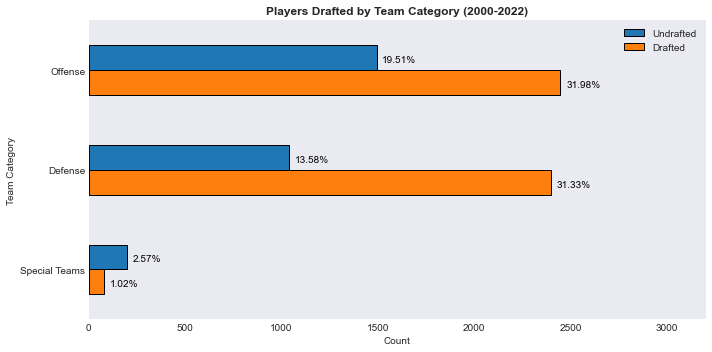

In [42]:
# plot visual breakdown of drafted by team category 
position_category = ['Offense', 'Defense', 'Special Teams']

data = {'Drafted': [total_offense_drafted, total_defense_drafted, total_st_drafted],
        'Undrafted': [total_offense_undrafted, total_defense_undrafted, total_st_undrafted]
       }

# create dataframe of positions & number of drafted
drafted = pd.DataFrame(data,
                       columns=['Undrafted', 'Drafted'], 
                       index = position_category)

plt.style.use('seaborn-dark')


fig, ax = plt.subplots(figsize=(10, 5))

drafted.plot(kind = 'barh',
             edgecolor = "black",
             linewidth = 1,
             ax = ax, stacked = False,
             xlim = (0, 3200))

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+ 30, i.get_y() + 0.17, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=10,
color='black')

# invert for largest on top 
ax.invert_yaxis()

plt.title('Players Drafted by Team Category (2000-2022)', weight = "bold")
plt.ylabel('Team Category')
plt.xlabel('Count')

plt.tight_layout()
plt.show()

In [43]:

drafted

,Undrafted,Drafted
Offense,1493,2447
Defense,1039,2397
Special Teams,197,78


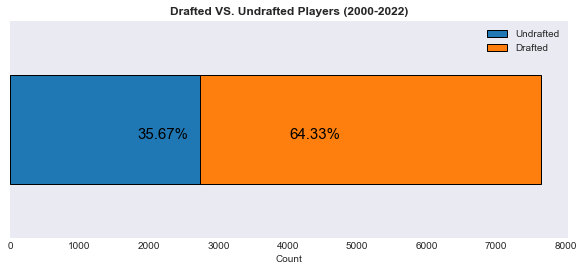

In [44]:
# create dict of drafted/undrafted with sums of each category
total = ['']

data = {'Undrafted': [drafted['Undrafted'].sum()],
        'Drafted': [drafted['Drafted'].sum()]
        }

# new drafted_total df
drafted_total = pd.DataFrame(data,
                       columns=['Undrafted', 'Drafted'],
                       index = total)

plt.style.use('seaborn-dark')

fig, ax = plt.subplots(figsize=(10, 4))

drafted_total.plot(kind = 'barh',
             edgecolor = "black",
             linewidth = 1,
             ax = ax, stacked = True)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()-900, i.get_y()+.21, \
            str(round((i.get_width()/total)*100, 2))+'%', 
            fontsize=15,
            color='black')

ax.set_xlabel('Count')

ax.set(ylabel=None)
ax.set_title('Drafted VS. Undrafted Players (2000-2022)', weight = "bold")
ax.legend()

plt.show()

In [ ]:
drafted_total

## Train-Test Split

In [ ]:
X = df.drop(['Drafted'], axis = 1)
y = df['Drafted']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

#### may need to find average of each metric at combine for each position to fill in the NaNs after the train test split
- fill NaNs with average for the position? or leave as 0?
- check and discuss 

## OHE

In [ ]:
def encode_feature_train(X_train, feature_name):
    """
    Helper function for transforming training data.  It takes in the full X dataframe and
    feature name, makes a one-hot encoder, and returns the encoder as well as the dataframe
    with that feature transformed into multiple columns of 1s and 0s
    """
    # make a one-hot encoder and fit it to the training data
    ohe = OneHotEncoder(categories="auto", handle_unknown="ignore")
    single_feature_df = X_train[[feature_name]]
    ohe.fit(single_feature_df)
    
    # call helper function that actually encodes the feature and concats it
    X_train = encode_feature(X_train, feature_name, ohe)
    
    return ohe, X_train

In [ ]:
def encode_feature(X, feature_name, ohe):
    """
    Helper function for transforming a feature into multiple columns of 1s and 0s. Used
    in both training and testing steps.  Takes in the full X dataframe, feature name, 
    and encoder, and returns the dataframe with that feature transformed into multiple
    columns of 1s and 0s
    """
    # create new one-hot encoded df based on the feature
    single_feature_df = X[[feature_name]]
    feature_array = ohe.transform(single_feature_df).toarray()
    ohe_df = pd.DataFrame(feature_array, columns=ohe.categories_[0], index=X.index)
    
    # drop the old feature from X and concat the new one-hot encoded df
    X = X.drop(feature_name, axis=1)
    X = pd.concat([X, ohe_df], axis=1)
    
    return X

In [ ]:
X_train

In [ ]:
# establish categorical feature names
categorical_feature_names = ['Pos', 'School']

# instantiates a ohe on the feature names
encoders = {}

for categorical_feature in categorical_feature_names:
    ohe,X_train = encode_feature_train(X_train, categorical_feature)
    encoders[categorical_feature] = ohe

In [ ]:
encoders

In [ ]:
X_train

## 1st Model

In [ ]:
logreg_model_more_iterations = LogisticRegression(random_state= 42, 
                                  penalty = 'none',
                                  max_iter = 4000)
logreg_model_more_iterations.fit(X_train, y_train)

In [ ]:
logreg_model_higher_tolerance = LogisticRegression(
                                                random_state=2022, 
                                                penalty='none', 
                                                max_iter = 5000,
                                                tol=60
)

logreg_model_higher_tolerance.fit(X_train, y_train)

In [ ]:
fix, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axes[0].set_title("More Iterations")
axes[1].set_title("Higher Tolerance")

plot_confusion_matrix(logreg_model_more_iterations, X_train, y_train,
                      ax=axes[0], cmap="plasma")
plot_confusion_matrix(logreg_model_higher_tolerance, X_train, y_train,
                      ax=axes[1], cmap="plasma");

In [ ]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [ ]:
logreg_model_more_iterations_results = ModelWithCV(
                                        logreg_model_more_iterations,
                                        'more_iterations',
                                        X_train,
                                        y_train
)
    
logreg_model_higher_tolerance_results = ModelWithCV(
                                        logreg_model_higher_tolerance,
                                        'higher_tolerance',
                                        X_train,
                                        y_train
)

model_results = [
    logreg_model_more_iterations_results,
    logreg_model_higher_tolerance_results
]


In [ ]:
f,axes = plt.subplots(ncols=2, sharey=True, figsize=(12, 6))

for ax, result in zip(axes, model_results):
    ax = result.plot_cv(ax)
    result.print_cv_summary()
plt.tight_layout();

In [ ]:
fig, ax = plt.subplots()

plot_roc_curve(logreg_model_more_iterations, X_train, y_train, 
               name='logreg_model_more_iterations', ax=ax)
plot_roc_curve(logreg_model_higher_tolerance, X_train, y_train, 
               name='logreg_model_higher_tolerance', ax=ax);

## Data Prep - Scaling

In [ ]:
#We need to perform Feature Scaling when we are dealing with Gradient Descent Based algorithms (Linear and Logistic Regression, Neural Network) 

scaler = StandardScaler()

scaler.fit(X_train)

In [ ]:
def scale_values(X, scaler):
    """
    Given a DataFrame and a fitted scaler, use the scaler to scale all of the features
    """
    scaled_array = scaler.transform(X)
    scaled_df = pd.DataFrame(scaled_array, columns=X.columns, index=X.index)
    return scaled_df

In [ ]:
X_train_scaled = scale_values(X_train, scaler)

In [ ]:
X_train_scaled.head()

## 3rd Model - After Scaling

In [ ]:
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train_scaled, y_train)

In [ ]:
fig, ax = plt.subplots()

fig.suptitle("Logistic Regression with Features Scaled")

plot_confusion_matrix(logreg_model, X_train_scaled, y_train, ax=ax, cmap="plasma");

In [ ]:
X_train.shape

In [ ]:
scaled_features_results = ModelWithCV(
                            logreg_model,
                            'scaled_features',
                            X_train_scaled,
                            y_train
)

In [ ]:
# Saving variable for convenience
model_results = scaled_features_results

# Plot CV results
fig, ax = plt.subplots()
ax = model_results.plot_cv(ax)
plt.tight_layout();
# Print CV results
model_results.print_cv_summary()

In [ ]:
plot_roc_curve(logreg_model, X_train_scaled, y_train)